In [225]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import sys
import math
import os
import numpy as np
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

# local code
sys.path.insert(1, "./code/")
from Utils import Utils # student's library
from Eval import Eval # student's library
from Extract import Extract # student's library


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/peterkong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [141]:
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [142]:
# sanity checks
#train_df.id.nunique()
# 19579

#train_df.author.unique()
# array(['EAP', 'HPL', 'MWS'], dtype=object)

In [143]:
Utils.check_for_nulls(train_df)

{'author': 0, 'id': 0, 'text': 0}

In [144]:
short_df = train_df[:20]
short_df.head(1)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP


In [145]:
# splitting data

# regular data
#     train: 19580 * .9 rows
#     test:  8393 rows
#     val:   19580 * .1 rows


if os.path.isfile('data/traindata.pickle'):
    traindata = pd.read_pickle('data/traindata.pickle')
    valdata   = pd.read_pickle('data/valdata.pickle')
    testdata  = pd.read_pickle('data/testdata.pickle')
else: 
    VAL_IDX  = math.ceil(len(train_df) * .8)
    TEST_IDX = math.ceil(len(train_df) * .9)

    traindata = train_df[:VAL_IDX]
    valdata   = train_df[VAL_IDX:TEST_IDX]
    testdata  = train_df[TEST_IDX:]

    print(VAL_IDX, TEST_IDX)

    traindata.to_pickle('data/traindata.pickle')
    valdata.to_pickle('data/valdata.pickle')
    testdata.to_pickle('data/testdata.pickle')

In [176]:
print("traindata: {}, valdata: {}, testdata: {}".format(len(traindata), len(valdata), len(testdata)))

traindata: 15664, valdata: 1958, testdata: 1957


In [177]:
# grammatical feature engineering 
# we want to include stopwords here

if os.path.isfile('data/train_gram_feats.pickle'):
    print("reading gram feats from pickle")
    train_gram_feats_df = pd.read_pickle('data/train_gram_feats_df.pickle')
    val_gram_feats_df   = pd.read_pickle('data/val_gram_feats_df.pickle')
    test_gram_feats_df  = pd.read_pickle('data/test_gram_feats_df.pickle')
else:
    seq_no = None
    train_gram_feats_df = Extract.gram_feats(traindata.text, None, seq_no)

    # need to remember so that val/test process
    # does not add additional columns
    GRAM_FEAT_LIST = list(train_gram_feats_df.columns)

    val_gram_feats_df = Extract.gram_feats(valdata.text, GRAM_FEAT_LIST, seq_no)
    test_gram_feats_df = Extract.gram_feats(testdata.text, GRAM_FEAT_LIST, seq_no)

    # there are 21 columns excluding sequence columns 
    # 7ary sequence columns can generate up to 2187
    
    train_gram_feats_df.to_pickle('data/train_gram_feats_df.pickle')
    val_gram_feats_df.to_pickle('data/val_gram_feats_df.pickle')
    test_gram_feats_df.to_pickle('data/test_gram_feats_df.pickle')    


In [268]:
# removes a singleton feature
for df in train_gram_feats_df, val_gram_feats_df, test_gram_feats_df:
    if 'SYM_count' in list(df.columns):
        df.drop('SYM_count', axis=1, inplace=True)
        
print(train_gram_feats_df.shape)
print(val_gram_feats_df.shape)
print(test_gram_feats_df.shape)

#set(GRAM_FEAT_LIST) - set(list(val_gram_feats_df.columns))

(15664, 23)
(1958, 23)
(1957, 23)


In [179]:
train_gram_feats_df.shape

(15664, 23)

In [180]:
# textual feature engineering
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_features=100)

train_text_feats = vectorizer.fit_transform(traindata.text)
Y_train = traindata.author 

val_text_feats = vectorizer.transform(valdata.text) 
Y_val = list(valdata.author)

test_text_feats = vectorizer.transform(testdata.text) 
Y_test = list(testdata.author)



In [181]:
#convert text feats to pandas
print(train_text_feats.shape)
print(val_text_feats.shape)
print(test_text_feats.shape)

cols = ["text_" + str(x) for x in range(train_text_feats.shape[1])]

train_text_feats_df = pd.DataFrame(train_text_feats.todense(), index=None, columns=cols)
val_text_feats_df = pd.DataFrame(val_text_feats.todense(), index=None, columns=cols)
test_text_feats_df = pd.DataFrame(test_text_feats.todense(), index=None, columns=cols)

print(train_text_feats_df.shape)
print(val_text_feats_df.shape)
print(test_text_feats_df.shape)


(15664, 100)
(1958, 100)
(1957, 100)
(15664, 100)
(1958, 100)
(1957, 100)


In [182]:
# concatenating features

X_train = train_gram_feats_df.fillna(0)#.join(train_text_feats_df).fillna(0)
X_val = val_gram_feats_df.fillna(0)#.join(val_text_feats_df).fillna(0)
X_test = test_gram_feats_df.fillna(0)#.join(test_text_feats_df).fillna(0)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(15664, 23)
(1958, 23)
(1957, 23)


In [183]:
#X_train.sum(axis=0).sort_values

In [184]:
#sanity checking
assert(list(X_train.columns) == list(X_val.columns))
assert(list(X_train.columns) == list(X_test.columns))

In [185]:
import numpy as np
import gensim

# http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

# this glove code is wrong type for later work
# with open("data/glove.42B.300d.txt", "rb") as lines:
#     w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
#            for line in lines}


# let X be a list of tokenized texts (i.e. list of lists of tokens)
# sentences param is token lists

# model = gensim.models.Word2Vec(short_sents, size=100)
# w2v = dict(zip(model.wv.index2word, model.wv.vectors))
# type(w2v)

In [186]:
#list(w2v.keys())[9990:9999]
# [b'iconic',
#  b'erp',
#  b'crest',
#  b'radius',
#  b'spiral',
#  b'nyse',
#  b'lotion',
#  b'oriental',
#  b'admire']

In [187]:
# a_key = list(w2v.keys())[9999]
# a_key.decode("utf-8")

In [188]:
#type(w2v[str.encode('owl')])

In [189]:
#https://radimrehurek.com/gensim/models/doc2vec.html
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#TaggedDocument does not filter or stem

# documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(short_sents)]
# model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# vector = model.infer_vector(["system", "response"])
# vector

In [190]:
# order of ops:
# just grammar features
# just tfidf vectorizer
# both

# kmeans

In [191]:
# linear svc
from sklearn.svm import LinearSVC

lin_clf = LinearSVC()
lin_clf.fit(X_train, Y_train) 
preds = lin_clf.predict(X_val)
preds

array(['EAP', 'EAP', 'EAP', ..., 'EAP', 'EAP', 'EAP'], dtype=object)

In [192]:
# evaluation

accuracy = Eval.get_accuracy(preds, Y_val)
print("Accuracy: ", accuracy)

Accuracy:  0.4964249233912155


In [220]:
import importlib
import Extract
import Utils
importlib.reload(Extract)
importlib.reload(Utils)
from Utils import Utils


In [269]:
# exploration


mws_df = train_df[train_df.author == 'MWS']
hpl_df = train_df[train_df.author == 'HPL']
eap_df = train_df[train_df.author == 'EAP']

cutoff = min([mws_df.shape[0], hpl_df.shape[0], eap_df.shape[0]])

# equalize corpus sizes to avoid bias during exploration
mws_df = mws_df[:cutoff]
hpl_df = hpl_df[:cutoff]
eap_df = eap_df[:cutoff]

mws_lexicon = Utils.build_lexicon(mws_df.text, STOPWORDS)
hpl_lexicon = Utils.build_lexicon(hpl_df.text, STOPWORDS)
eap_lexicon = Utils.build_lexicon(eap_df.text, STOPWORDS)

# sanity check
assert(cutoff * 3 == len(mws_df) + len(hpl_df) + len(eap_df))

# add grammatical features (for exploration this time, not training)
mws_gram_feats_df = Extract.gram_feats(mws_df.text, None, None)
hpl_gram_feats_df = Extract.gram_feats(hpl_df.text, None, None)
eap_gram_feats_df = Extract.gram_feats(eap_df.text, None, None)

mws_gram_feats_df.describe()

In [329]:
# looks like sentence length values are consistently higher by at least a degree of magnitude
# so we'll take the log
for df in [mws_gram_feats_df, hpl_gram_feats_df, eap_gram_feats_df]:
    df['sent_len'] = df['sent_len'].apply(lambda x: math.log(x))
    df.rename(inplace=True, columns={'sent_len': 'log_sent_len'})


In [259]:
# data viz

def plot_word_freq(lexicon, name, quantity=20):
    plt.rcdefaults()
    fig, ax = plt.subplots()

    elems = [x[0] for x in lexicon[:quantity]]
    y_pos = np.arange(quantity)
    vals = [x[1] for x in lexicon[:quantity]]

    ax.barh(y_pos, vals, align='center',
            color='green', ecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(elems)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Corpus-wide frequency')
    ax.set_title(name + ' - Word Frequencies')

    plt.show()
 
authors = {'MWS': mws_lexicon, 'HPL': hpl_lexicon, 'EAP': eap_lexicon}

pd.set_option('display.max_colwidth', -1)
print("Example MWS sentence: \n{}\n".format(mws_df.text[:1].to_string()))
print("Example HPL sentence: \n{}\n".format(hpl_df.text[:1].to_string()))
print("Example EAP sentence: \n{}\n".format(eap_df.text[:1].to_string()))
pd.set_option('display.max_colwidth', 80)

# for key in authors: 
#     plot_word_freq(authors[key], key)


Example MWS sentence: 
3    How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.

Example HPL sentence: 
1    It never once occurred to me that the fumbling might be a mere mistake.

Example EAP sentence: 
0    This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.



In [263]:
start w violion for just eap, all 23 features (not summed)

(6044, 3)
(5635, 3)
(7900, 3)


In [330]:
mws_gram_feats_df.head()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,log_sent_len
0,6,6.0,2,2.0,2.0,NaN,6,1.0,NaN,1.0,...,NaN,1.000000,3.000000,0,0,0,0,0,0,0.514590
1,15,11.0,6,4.0,6.0,NaN,17,NaN,2.0,7.0,...,NaN,1.133333,2.666667,0,1,0,0,0,0,0.596748
2,1,5.0,0,3.0,3.0,NaN,7,NaN,NaN,2.0,...,NaN,7.000000,0.000000,0,0,0,0,0,0,0.472115
3,3,2.0,0,NaN,1.0,NaN,3,NaN,1.0,4.0,...,NaN,1.000000,0.000000,0,0,0,0,0,1,0.432928
4,7,6.0,3,4.0,6.0,NaN,7,NaN,1.0,4.0,...,NaN,1.000000,3.000000,0,0,0,0,0,0,0.540235


In [328]:
mws_gram_feats_df.describe()

,ADJ_count,ADP_count,ADV_count,CCONJ_count,DET_count,INTJ_count,NOUN_count,NUM_count,PART_count,PRON_count,...,X_count,adj_noun_ratio,adv_verb_ratio,bang_count,colon_count,ellipse_count,lparen_count,quote_count,semicolon_count,sent_len
count,5635.000000,5204.000000,5635.000000,4003.000000,4863.000000,183.000000,5635.000000,543.000000,2256.000000,4732.000000,...,20.000000,5635.000000,5635.000000,5635.0,5635.000000,5635.0,5635.0,5635.000000,5635.000000,5635.000000
mean,3.554392,4.177364,1.587400,1.880839,3.082459,1.169399,5.607986,1.206262,1.435284,2.749155,...,1.200000,1.656980,2.367340,0.0,0.057675,0.0,0.0,0.080213,0.442413,1.563314
std,3.675758,3.799392,1.814904,1.305063,2.880091,0.627872,5.432861,0.524138,0.867382,2.506438,...,0.695852,1.338079,2.417259,0.0,0.258424,0.0,0.0,0.382373,0.750584,0.138663
min,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.113344
25%,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.488584
50%,3.000000,3.000000,1.000000,2.000000,2.000000,1.000000,5.000000,1.000000,1.000000,2.000000,...,1.000000,1.400000,2.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.581000
75%,5.000000,5.000000,2.000000,2.000000,4.000000,1.000000,7.000000,1.000000,2.000000,4.000000,...,1.000000,2.000000,3.500000,0.0,0.000000,0.0,0.0,0.000000,1.000000,1.659655
max,116.000000,130.000000,41.000000,27.000000,96.000000,6.000000,193.000000,5.000000,17.000000,64.000000,...,4.000000,14.000000,18.000000,0.0,3.000000,0.0,0.0,10.000000,6.000000,2.133860


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))



# generate some random test data
all_data = [np.random.normal(0, std, 100) for std in range(6, 10)]

# plot violin plot
axes[0].violinplot(all_data,
                   showmeans=False,
                   showmedians=True)
axes[0].set_title('Violin plot')

# plot box plot
axes[1].boxplot(all_data)
axes[1].set_title('Box plot')

# adding horizontal grid lines
for ax in axes:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(all_data))])
    ax.set_xlabel('Four separate samples')
    ax.set_ylabel('Observed values')

# add x-tick labels
plt.setp(axes, xticks=[y + 1 for y in range(len(all_data))],
         xticklabels=list(mws_gram_feats_df.columns))
plt.show()

In [332]:
def plot_box(df, subset):
    features = {
        'tag_features': [
             'ADJ_count',
             'ADP_count',
             'ADV_count',
             'CCONJ_count',
             'DET_count',
             'NOUN_count',
             'PRON_count',
             'VERB_count'],
        'punc_features': [
            'bang_count',
            'colon_count',
            'ellipse_count',
            'lparen_count',
            'quote_count',
            'semicolon_count'],
        'ratio_features': [
             'adj_noun_ratio',
             'adv_verb_ratio',
             'log_sent_len']
    }
    
    fig, ax = plt.subplots()
    boxplot = df.boxplot(column=features[subset], \
        showfliers=False, fontsize=6, figsize=None)
    plt.show()

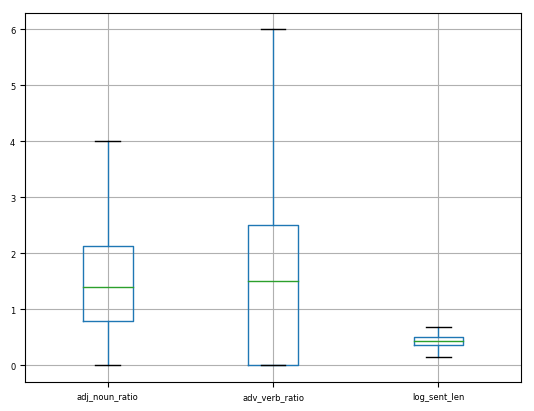

In [334]:
plot_box(eap_gram_feats_df, 'ratio_features')

In [320]:
START HERE: set up tryptich plots

,bar,foo
0,1,4.605170
1,2,5.298317


In [ ]:
import time
timenow = time.asctime( time.localtime(time.time()) )
print("Finished at: ", timenow)